In [1]:
# Import required packages
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os

start_time = time.time()

# Fix random seeds for reproducibility
np.random.seed(1234)
tf.set_random_seed(1234)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random


from tensorflow.python.eager import context
from tensorflow.python.framework import ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.training import optimizer
from PCGrad import PCGrad

GATE_OP = 1

In [3]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class HSMC:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, layers_U, layers_S, lam = 1.0, num_tasks=2):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x
        self.N_u = X_u.shape[0]
        self.N_r = X_r.shape[0]

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        # Regularization parameters
        self.lam = lam
        self.num_tasks = num_tasks
        
        ######################################################################################
        # Neural network structures
        self.layers_U = layers_U
        self.layers_S = layers_S
        # Initialize network weights and biases
        self.weights_U, self.biases_U = self.initialize_NN(layers_U)
        
        ######################################################################################
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        # Define placeholders and computational graph
        self.Xu_tf = tf.placeholder(tf.float32, shape=(None, self.X_u.shape[1]))
        self.Yu_tf = tf.placeholder(tf.float32, shape=(None, self.Y_u.shape[1]))
        self.Xr_tf = tf.placeholder(tf.float32, shape=(None, self.X_r.shape[1]))
        
        # Evaluate prediction
        self.u_pred = self.net_u(self.Xu_tf)
        self.r_pred = self.get_r(self.Xr_tf)        
        
        # Evaluate loss
        self.loss_u = tf.reduce_mean(tf.square(self.Yu_tf[:,0:1] - self.u_pred[:,0:1]))
        self.loss_r = self.r_pred
        
         # Combine Loss Equal-Weighted
        #self.loss = self.loss_u + self.lam *self.loss_r
        
        #PCGrad optimizer
        self.optimizer = PCGrad(tf.train.AdamOptimizer()) # wrap your favorite optimizer
        self.loss = [self.loss_u, self.loss_r]# a list of per-task losses
        
        print(len(self.loss))
        assert len(self.loss) == self.num_tasks
        
        self.train_op = self.optimizer.minimize(self.loss,var_list=tf.nest.flatten([self.weights_U, self.biases_U]))
        
        
        # Logger
        self.loss_u_log = []
        self.loss_r_log = []
        self.saver = tf.train.Saver()
        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.nn.softmax(tf.add(tf.matmul(H, W), b)) ##TZ  - use softmax in the last layer
        return H
    
    # Forward pass for u
    def net_u(self, x):
        u = self.forward_pass(x,
                              self.layers_U,
                              self.weights_U,
                              self.biases_U)
        return u
    
    # Forward pass for f
    def get_r(self, x):
        #prediction for collocation points
        u = self.net_u(x)
        u1 = u[:,0:1]
        u2 = u[:,1:2]
        u3 = u[:,2:3]
        
        #derivatives of state probability
        u_x_1 = tf.gradients(u1, x)[0]/self.sigma_x
        u_x_2 = tf.gradients(u2, x)[0]/self.sigma_x
        u_x_3 = tf.gradients(u3, x)[0]/self.sigma_x
        
        #time stamp  
        t_id = x*self.sigma_x + self.mu_x
        
        #calculate residuals
        residual_1 = u_x_1-(-1.286e-4*u1)
        residual_2 = u_x_2-(5.6e-5*u1-1.006e-4*u2)
        residual_3 = u_x_3-(7.26e-5*u1+1.006e-4*u2)
        
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        return residual

    # Callback to print the loss at every optimization step
    def callback(self, loss_u, loss_r):
        print('Loss_u: %.3e, Loss_r: %.3e' % 
                      (loss_u, loss_r))

    # Trains the model by minimizing the MSE loss using Adam
    def train(self, nIter = 10000): 
        
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.Xu_tf: self.X_u, self.Yu_tf: self.Y_u,
                   self.Xr_tf: self.X_r}

        start_time = timeit.default_timer()
        
        for it in tqdm(range(nIter)):                 
            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)
            
            # Print
            if it % 1000 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value = self.sess.run(self.loss_u, tf_dict)
                loss_r_value = self.sess.run(self.loss_r, tf_dict)
                self.loss_u_log.append(loss_u_value)
                self.loss_r_log.append(loss_r_value)
                #print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' % 
                #      (it, loss_value, loss_u_value, loss_r_value, elapsed))
                print(loss_value)
                start_time = timeit.default_timer()
            
    # Trains the model by minimizing the MSE loss using L-BFGS
    def fine_tune(self):
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.Xu_tf: self.X_u, self.Yu_tf: self.Y_u,
                   self.Xr_tf: self.X_r}

        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss_u, self.loss_r], 
                                loss_callback = self.callback)
        
    # Evaluates predictions at collocation points           
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_x)/self.sigma_x
        tf_dict = {self.Xu_tf: X_star}       
        u_star = self.sess.run(self.u_pred, tf_dict) 
        return u_star
    
    # Evaluates predictions at test points           
    def predict_r(self, X_star):     
        X_star = (X_star - self.mu_x)/self.sigma_x
        tf_dict = {self.Xr_tf: X_star}       
        r_star = self.sess.run(self.r_pred, tf_dict) 
        return r_star

In [4]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 5000                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([60000.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [5]:
######################################################################################
# Test data for validating the model predictions
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star) #N_star = x_star.shape[0] 

In [6]:
######################################################################################
# Fully-connected neural net architecture (dimensions of each layer)
n_layers = 1
layers_U = np.array([1,50,50,3])
layers_S = np.array([1,50,50,3])
#  Define PINN model
model = HSMC(x_u, y_u, x_r, layers_U, layers_S, lam=1, num_tasks=2)

Device mapping: no known devices.
2
<class 'list'>
[<tf.Tensor 'gradients_4/AddN_10:0' shape=(1, 50) dtype=float32>, <tf.Tensor 'gradients_4/AddN_8:0' shape=(50, 50) dtype=float32>, <tf.Tensor 'gradients_4/AddN_5:0' shape=(50, 3) dtype=float32>, <tf.Tensor 'gradients_4/AddN_9:0' shape=(1, 50) dtype=float32>, <tf.Tensor 'gradients_4/AddN_6:0' shape=(1, 50) dtype=float32>, <tf.Tensor 'gradients_4/AddN_3:0' shape=(1, 3) dtype=float32>]
var list:  [<tf.Variable 'Variable:0' shape=(1, 50) dtype=float32_ref>, <tf.Variable 'Variable_2:0' shape=(50, 50) dtype=float32_ref>, <tf.Variable 'Variable_4:0' shape=(50, 3) dtype=float32_ref>, <tf.Variable 'Variable_1:0' shape=(1, 50) dtype=float32_ref>, <tf.Variable 'Variable_3:0' shape=(1, 50) dtype=float32_ref>, <tf.Variable 'Variable_5:0' shape=(1, 3) dtype=float32_ref>]
Tensor("loop_body/concat/pfor/concat:0", shape=(2, 2803), dtype=float32)
0 <tf.Variable 'Variable:0' shape=(1, 50) dtype=float32_ref>
1 <tf.Variable 'Variable_2:0' shape=(50, 50) dt

In [7]:
######################################################################################
# Load stored model
# model.saver.restore(model.sess, "../SavedModels/elliptic1d.ckpt")
# Train model using full batch gradient descent
n_iter = 1
model.train(n_iter)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]

[0.583206, 5.7570397e-09]


In [8]:
######################################################################################
# Compute prediction using the trained model
u_pred = model.predict_u(x_star)
u_pred.shape

(5001, 3)

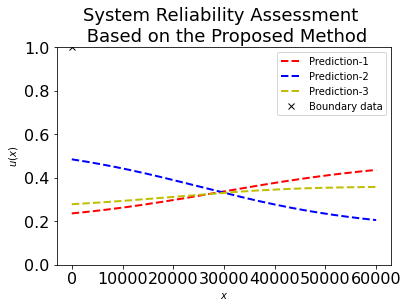

In [9]:
# Plotting
plt.figure(1)
plt.plot(x_star[:,0:1], u_pred[:,0:1], 'r--', linewidth = 2, label = "Prediction-1")
plt.plot(x_star[:,0:1], u_pred[:,1:2], 'b--', linewidth = 2, label = "Prediction-2")
plt.plot(x_star[:,0:1], u_pred[:,2:3], 'y--', linewidth = 2, label = "Prediction-3")

plt.plot(x_u[:,0:1], y_u[:,0:1], 'kx', linewidth = 2, label = "Boundary data")
#plt.legend(frameon=False, loc='center right')
plt.legend(loc='best',bbox_to_anchor=(1,1))
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('System Reliability Assessment \n Based on the Proposed Method', fontsize=18)
#plt.yscale("log")
#plt.xlim([0,500])
plt.ylim([0,1])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

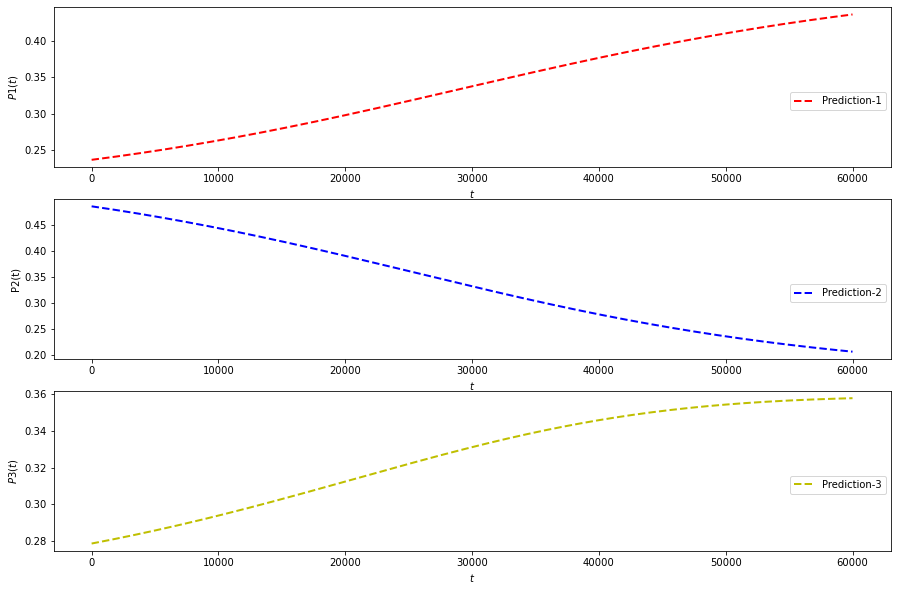

In [10]:
## subplot (for each state)
# Plotting
ax = plt.figure(1,figsize=(15,10))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(3, 1, 1)
plt.plot(x_star[:,0:1], u_pred[:,0:1], 'r--', linewidth = 2, label = "Prediction-1")
plt.legend(loc='best',bbox_to_anchor=(1,0.5))
plt.xlabel('$t$')
plt.ylabel('$P1(t)$')
#plt.xlim([0,500])

plt.subplot(3, 1, 2)
plt.plot(x_star[:,0:1], u_pred[:,1:2], 'b--', linewidth = 2, label = "Prediction-2")
plt.legend(loc='best',bbox_to_anchor=(1,0.5))
plt.xlabel('$t$')
plt.ylabel('P2(t)')
#plt.xlim([0,500])

plt.subplot(3, 1, 3)
plt.plot(x_star[:,0:1], u_pred[:,2:3], 'y--', linewidth = 2, label = "Prediction-3")
plt.legend(loc='best',bbox_to_anchor=(1,0.5))
plt.xlabel('$t$')
plt.ylabel('$P3(t)$')
#plt.xlim([0,500])

plt.show()

In [11]:
################
## output results as csv file
mc_output  = np.column_stack((np.array(x_star), u_pred))
fileName = 'mspm_pidl_' + str(N_r) + '_' + str(n_iter) + '_' + str(n_layers) + '.csv'
np.savetxt(fileName, mc_output, delimiter=",")

In [12]:
## used time
end_time = time.time() 
used_time = end_time - start_time
print("--- %s seconds ---" % (used_time))

--- 5.810343503952026 seconds ---


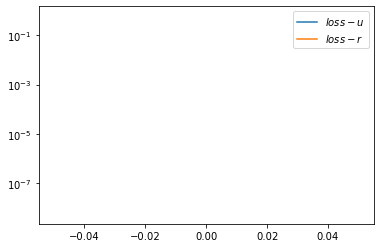

In [13]:
### plot loss function every 50 iterations
fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)
ax.plot(model.loss_u_log, label = '$loss-u$')
ax.plot(model.loss_r_log, label = '$loss-r$')
ax.set_yscale('log')
plt.legend()

plt.show()

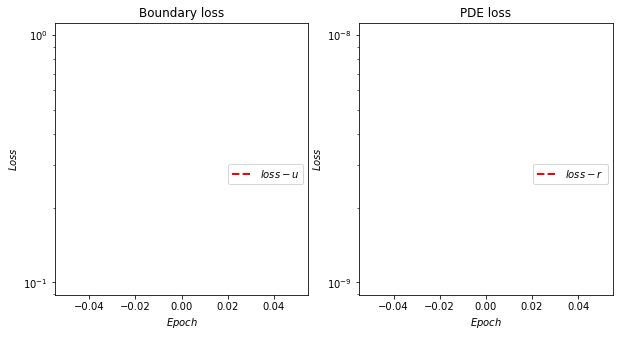

In [14]:
## subplot (for each state)
# Plotting
ax = plt.figure(1,figsize=(10,5))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(model.loss_u_log, 'r--', linewidth = 2, label = "$loss-u$")
plt.legend(loc='best',bbox_to_anchor=(1,0.5))
plt.title('Boundary loss')
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(model.loss_r_log, 'r--', linewidth = 2, label = "$loss-r$")
plt.legend(loc='best',bbox_to_anchor=(1,0.5))
plt.title('PDE loss')
plt.xlabel('$Epoch$')
plt.ylabel('$Loss$')
plt.yscale("log")

plt.show()